implement and compare:
- Decision tree
- Naive Bayes
- K-means clustering
- DBSCAN

sklearn only:
- Multi-layer Perceptron
- KNN
- SVM
- Random Forest
- Agglomerative Clustering

classification metrics:
- precision
- recall
- F1-score
- accuracy
- confusion matrices

clustering evaluation:
- RAIN CHECK (may require admission of mistake in proposal)

TODO:
- deal with plot_data using ALL the data, i.e. don't test on the training data

In [1]:
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from scipy.stats import mode

import numpy as np

In [2]:
iris = load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [17]:
# modified from:
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
def plot_data(classifier = None):
  plot_colors = "ryb"
  plot_step = 0.02
  n_classes = 3

  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # subplots
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)

    # optional classifier for optional decision boundary
    if classifier is not None:
      clf = classifier().fit(X, y) # train
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(
          np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
      )
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
  
  fig = plt.gcf()
  fig.set_size_inches(18, 9)
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")

  plt.show()

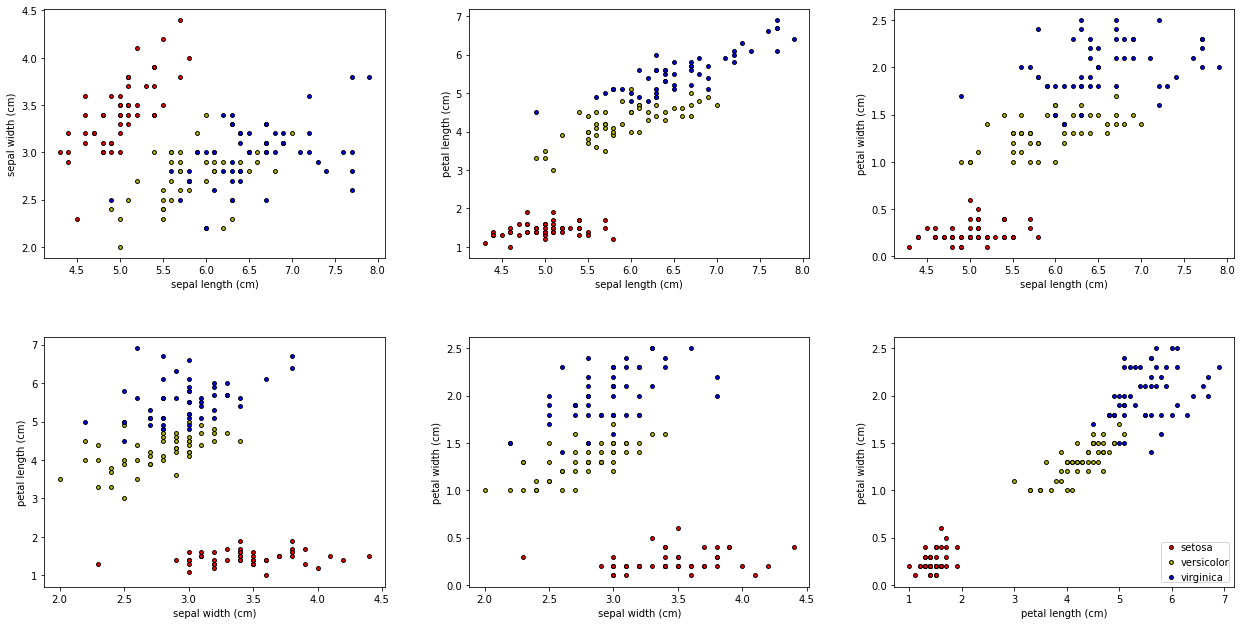

In [6]:
plot_data()

In [25]:
class SimpleCondition:
  func = None
  outcomes = None

  def __init__(self, func, outcomes):
    self.func = func
    self.outcomes = outcomes
  
  def __call__(self, x):
    return self.func(x)
  
  def __lt__(self, other):
    # needs to be implemented so that i can sort
    # arrays of tuples of gini indices and their
    # corresponding conditions.
    return hash(self) < hash(other)

class SimpleDecisionTreeNode:
  label = None
  condition = None
  children = {}
  
  def __init__(self, condition = None, label = None):
    self.label = label
    self.condition = condition

  def isleaf(self):
    return self.label is not None
  
  def add_child(self, outcome, N):
    self.children[outcome] = N
  
  def outcomes(self):
    return self.children.keys()
  
  def traverse(self, x):
    if self.isleaf():
      return self.label
    return self.children[self.condition(x)].traverse(x)

class SimpleDecisionTree:
  root = None
  
  def __init__(self):
    pass

  def fit(self, X, y):
    self.root = SimpleDecisionTree.gentree(X, y)
    return self

  @staticmethod
  def gini(X, y):
    return 1 - sum([(
        np.count_nonzero(y == c) / len(y)) ** 2 
        for c in set(y)])

  @staticmethod
  def gini_ind_cont(m, X, y):
    le_inds = X <= m
    g_inds = X > m
    g1 = np.count_nonzero(le_inds) * SimpleDecisionTree.gini(X[le_inds], y[le_inds])
    g2 = np.count_nonzero(g_inds) * SimpleDecisionTree.gini(X[g_inds], y[g_inds])
    return (g1 + g2) / len(X)


  @staticmethod
  def attribute_selection(X, y):
    conds = []
    for col in range(X.shape[-1]):
      # https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
      inds = X[:, col].argsort()
      sortedX = X[inds][:, col]
      sortedy = y[inds]
      mids = []
      for i in range(len(sortedX) - 1):
        mids.append((sortedX[i] + sortedX[i + 1]) / 2)
      gini_inds = []
      for m in mids:
        gini_inds.append(SimpleDecisionTree.gini_ind_cont(m, sortedX, sortedy))
      g, m = sorted(list(zip(gini_inds, mids)))[0]
      conds.append((g, SimpleCondition(func=lambda x: x[col] <= m, outcomes=[True, False])))
    return sorted(conds)[0][1]
      
  @staticmethod
  def gentree(X, y):
    n = SimpleDecisionTreeNode()
    majority = mode(y).mode[0]
    if len(set(y)) == 1:
      n.label = majority
      return n
    # NOT dealing with discrete-valued attributes here
    cond = SimpleDecisionTree.attribute_selection(X, y)
    n.condition = cond
    for j in cond.outcomes:
      inds = np.where(cond(X) == j)[0]
      Xj = X[inds]
      if len(Xj) == 0:
        n.add_child(j, SimpleDecisionTreeNode(label=majority))
      else:
        n2 = SimpleDecisionTree.gentree(Xj, y[inds])
        n.add_child(j, n2)
    return n

  def traverse(self, x):
    return self.root.traverse(x)

  def predict(self, X):
    return np.array([self.traverse(x) for x in X])

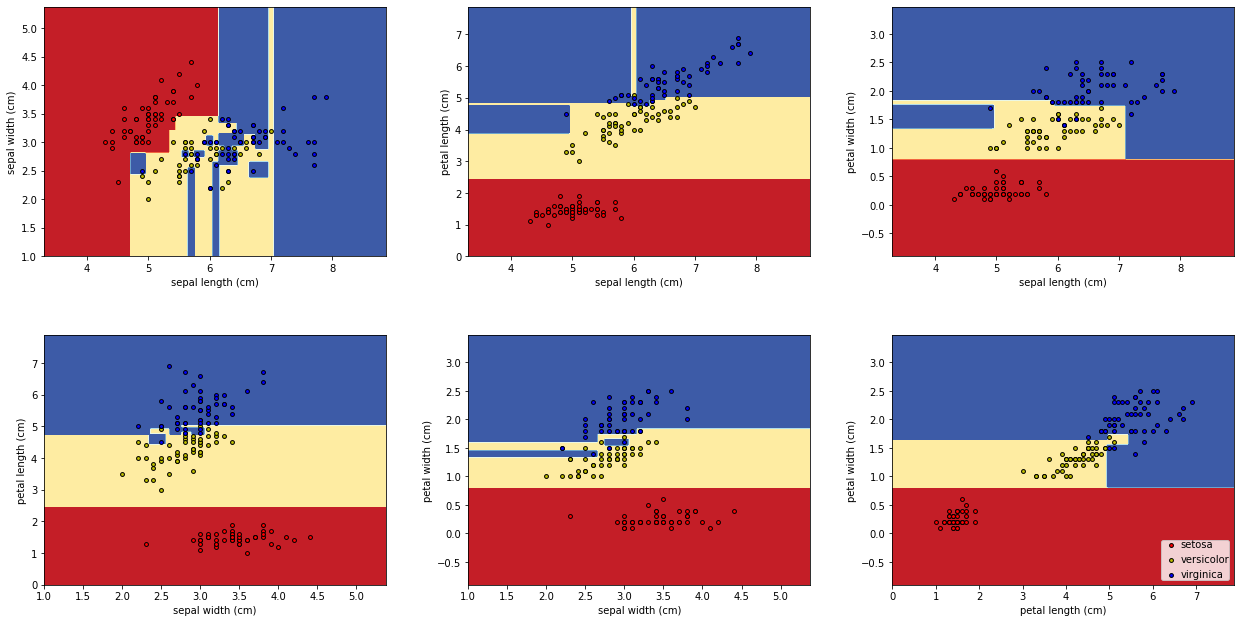

In [8]:
# decision tree
plot_data(DecisionTreeClassifier)

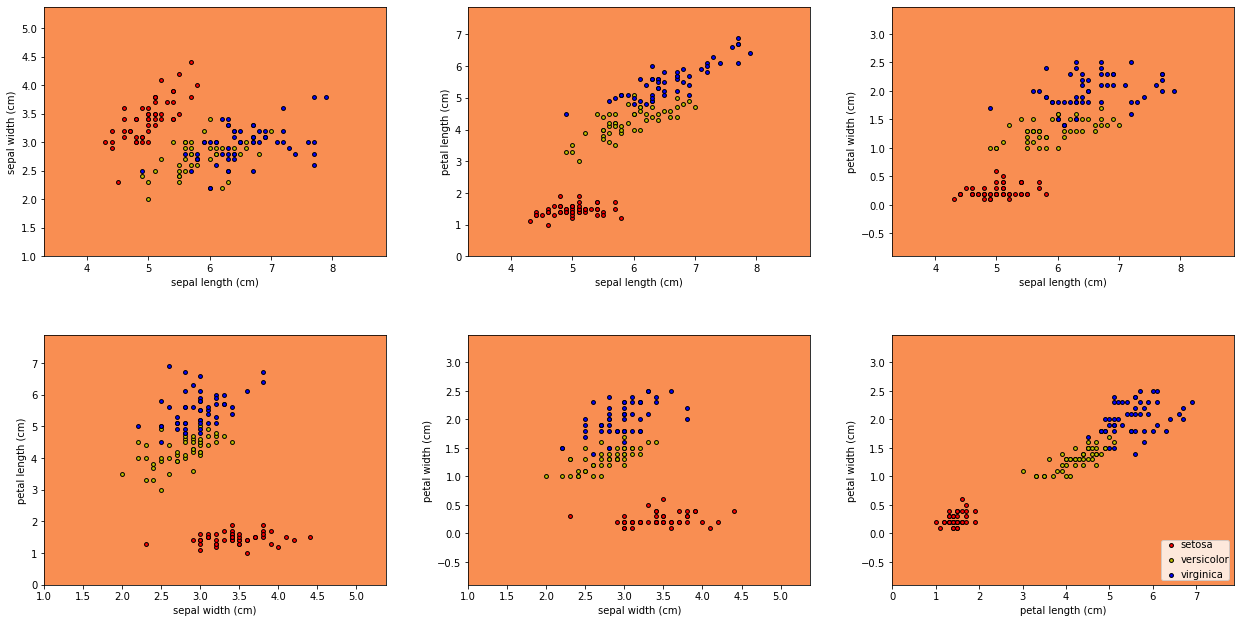

In [26]:
plot_data(SimpleDecisionTree)

In [9]:
class SimpleNaiveBayes:
  def __init__(self):
    pass

  def fit(self, X, y):
    pass

  def predict(self, X):
    pass

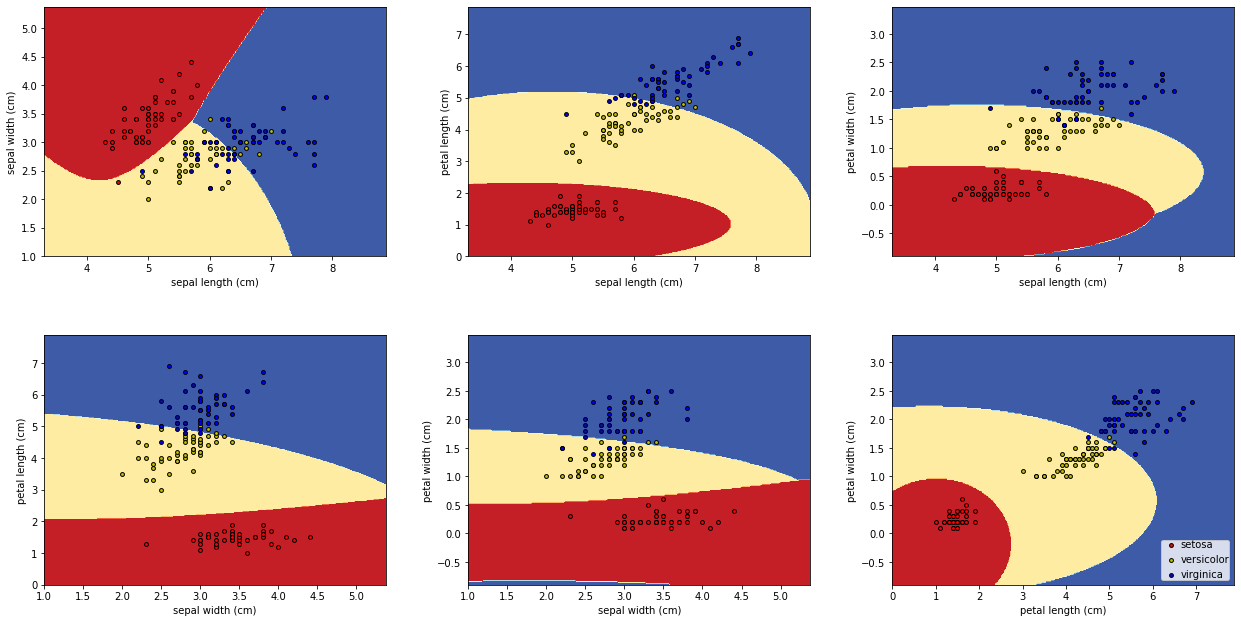

In [10]:
# naive bayes
plot_data(GaussianNB)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

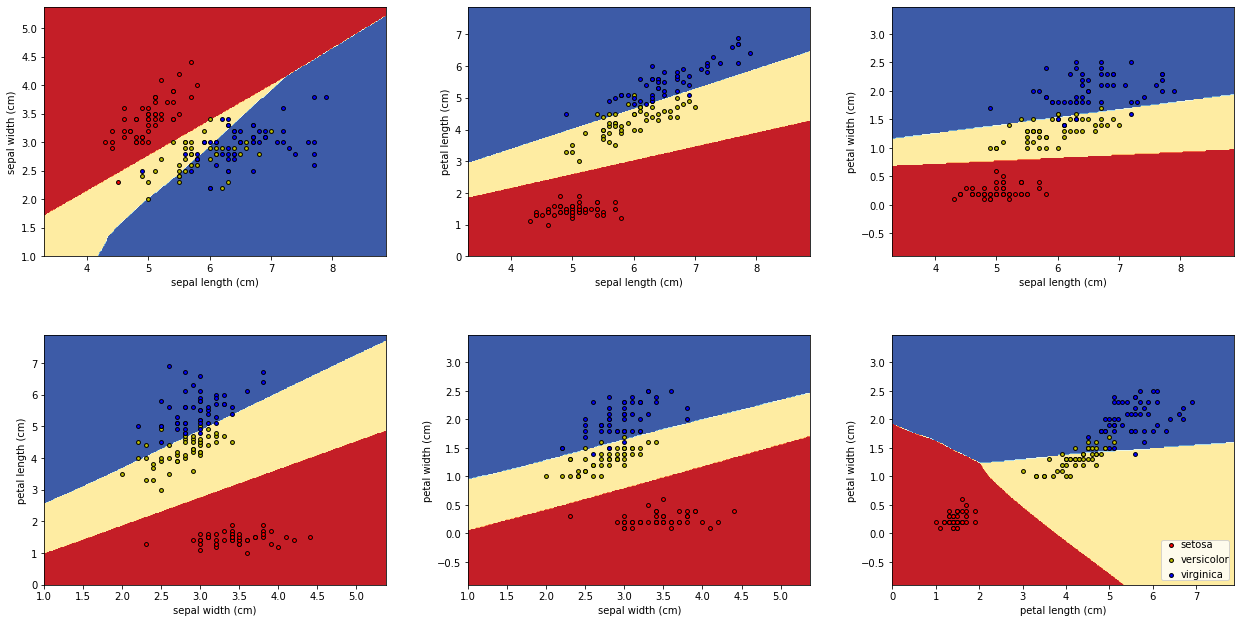

In [11]:
# multi-layer perceptron
plot_data(MLPClassifier)

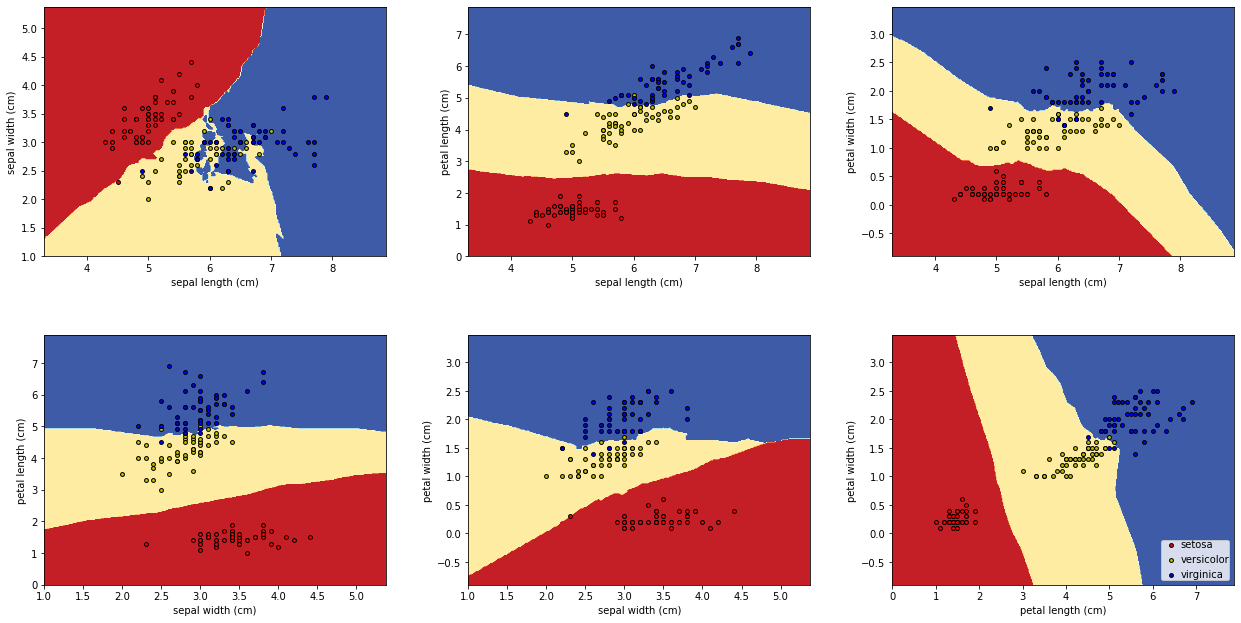

In [12]:
# k nearest neighbors
plot_data(KNeighborsClassifier)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


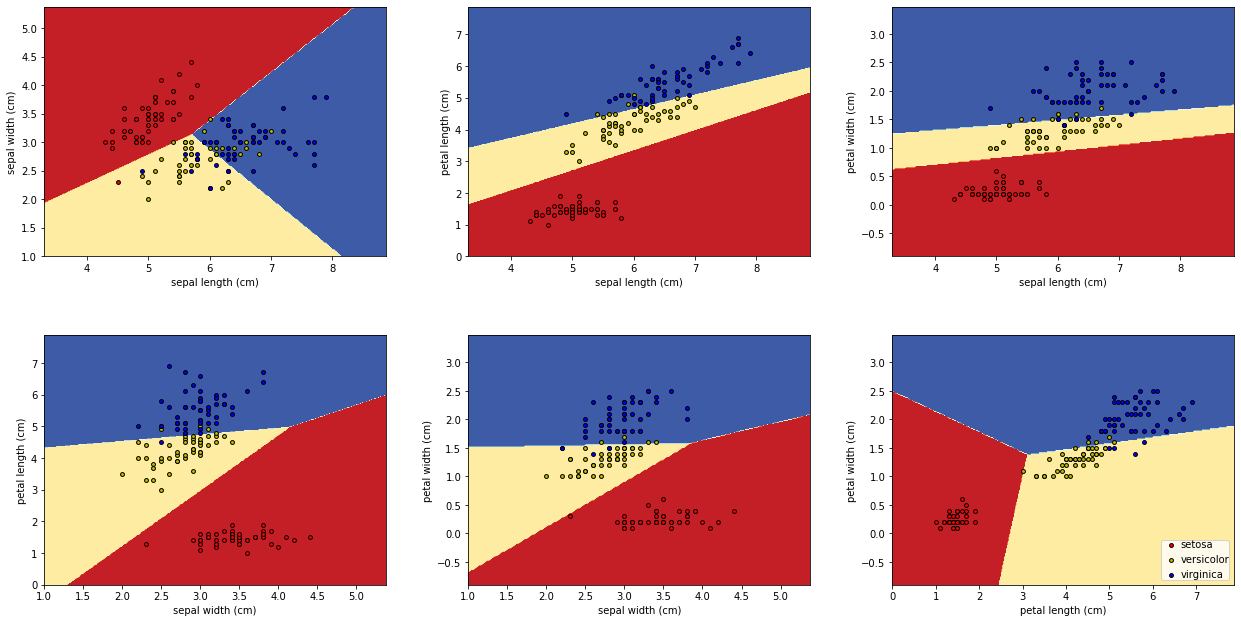

In [13]:
# support vector machine
plot_data(LinearSVC)

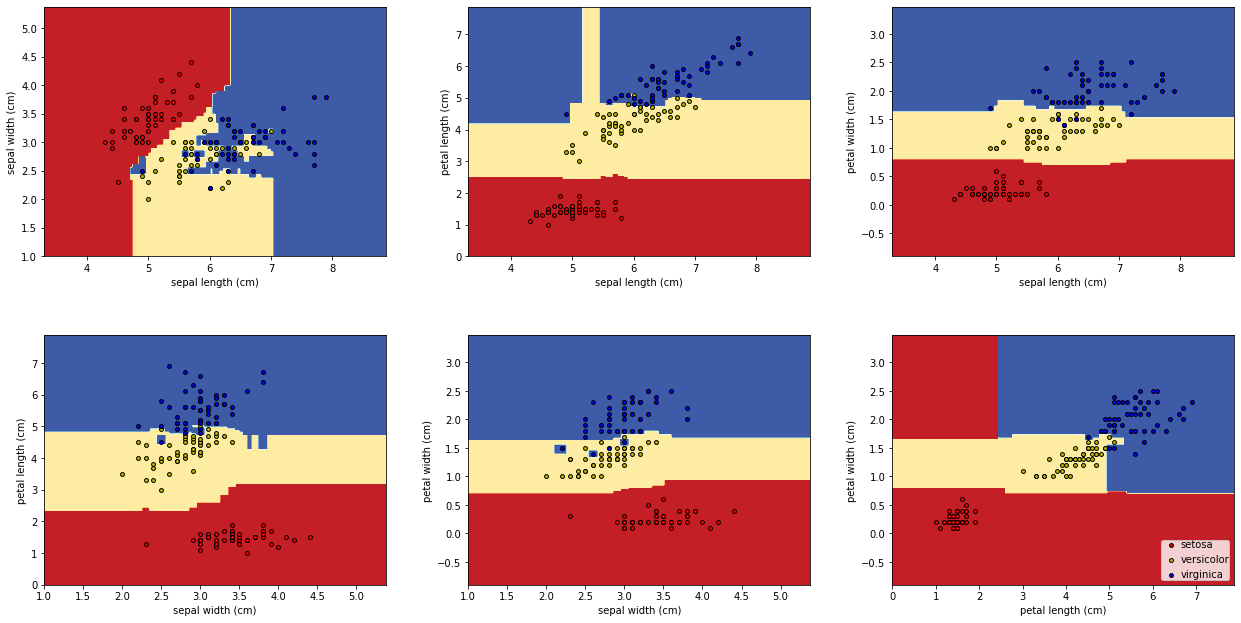

In [14]:
# random forest
plot_data(RandomForestClassifier)